In [1]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDSAZXD/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDSAZXD/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [2]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [3]:
train_data_len = info.splits['train'].num_examples
test_data_len = info.splits['test'].num_examples
train_data_len, test_data_len

(3680, 3669)

In [4]:
import tensorflow as tf

def load_image(datapoint):
    img = tf.image.resize(datapoint['image'], (128,128))
    mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))

    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1

    return img, mask

In [5]:
train_dataset = dataset['train'].map(load_image)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)

test_dataset = dataset['test'].map(load_image)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(1)

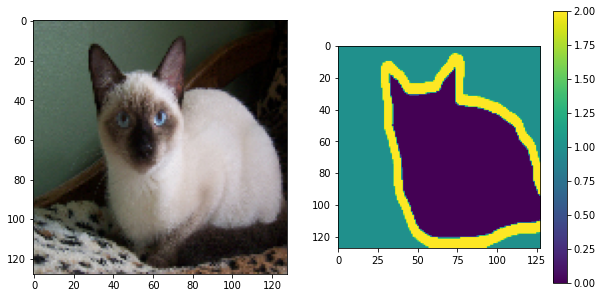

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.imshow(img[3])
    
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask[3], axis=2))
    plt.colorbar()

In [8]:
def REDNet_segmentation(num_layers):
    conv_layers = []
    deconv_layers = []
    residual_layers = []

    inputs = tf.keras.layers.Input(shape=(None,None,3))
    conv_layers.append(tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='relu'))

    for i in range(num_layers-1):
        conv_layers.append(tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        deconv_layers.append(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', activation='relu'))

    deconv_layers.append(tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='softmax'))

    x = conv_layers[0](inputs)

    for i in range(num_layers-1):
        x = conv_layers[i+1](x)
        if i % 2 == 0:
            residual_layers.append(x)
    
    for i in range(num_layers-1):
        if i % 2 == 1:
            x = tf.keras.layers.Add()([x, residual_layers.pop()])
            x = tf.keras.layers.Activation('relu')(x)
        x = deconv_layers[i](x)

    x  = deconv_layers[-1](x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

In [9]:
model = REDNet_segmentation(15)
model.compile(optimizer=tf.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(train_dataset, epochs=20, steps_per_epoch=train_data_len//16, validation_data=test_dataset, validation_steps=test_data_len)

Epoch 1/20
230/230 [==============================] - 82s 334ms/step - loss: 0.9264 - accuracy: 0.5477 - val_loss: 0.8128 - val_accuracy: 0.5917
Epoch 2/20
230/230 [==============================] - 76s 331ms/step - loss: 0.7626 - accuracy: 0.6454 - val_loss: 0.7732 - val_accuracy: 0.6463
Epoch 3/20
230/230 [==============================] - 76s 331ms/step - loss: 0.7075 - accuracy: 0.6843 - val_loss: 0.7260 - val_accuracy: 0.6733
Epoch 4/20
230/230 [==============================] - 76s 331ms/step - loss: 0.6561 - accuracy: 0.7105 - val_loss: 0.6640 - val_accuracy: 0.7016
Epoch 5/20
230/230 [==============================] - 76s 331ms/step - loss: 0.6151 - accuracy: 0.7309 - val_loss: 0.6202 - val_accuracy: 0.7331
Epoch 6/20
230/230 [==============================] - 76s 331ms/step - loss: 0.5888 - accuracy: 0.7463 - val_loss: 0.5767 - val_accuracy: 0.7550
Epoch 7/20
230/230 [==============================] - 76s 331ms/step - loss: 0.5625 - accuracy: 0.7604 - val_loss: 0.5540 - val_ac

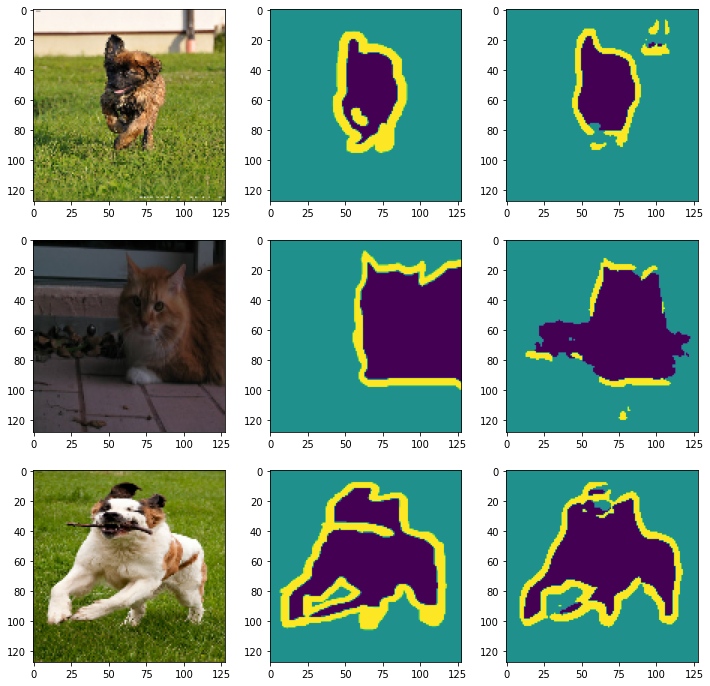

In [11]:
plt.figure(figsize=(12,12))
for idx, (img, mask) in enumerate(test_dataset.take(3)):
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img[0])
    
    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask[0], axis=2))

    predict= tf.argmax(model.predict(img), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(predict[0])

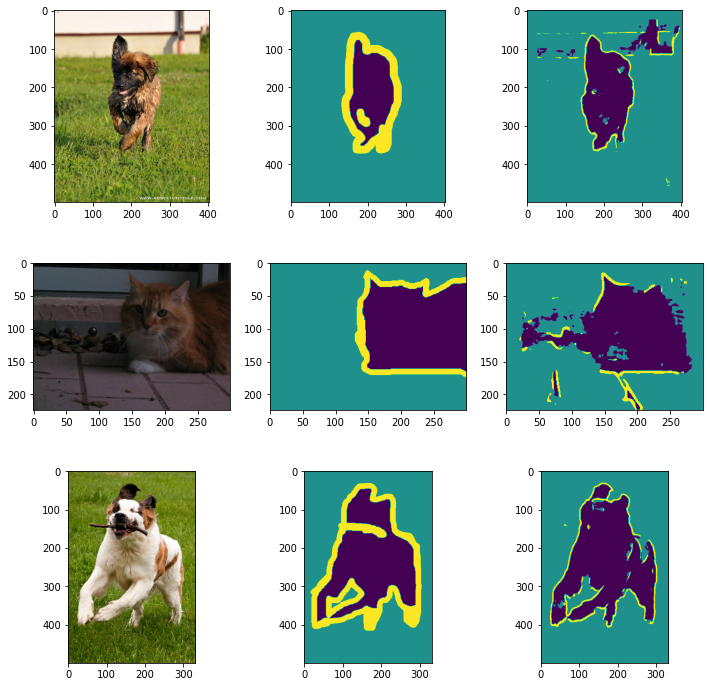

In [13]:
plt.figure(figsize=(12,12))
for idx, datapoint in enumerate(dataset['test'].take(3)):
    img = datapoint['image']
    mask = datapoint['segmentation_mask']

    img = tf.cast(img, tf.float32)
    img = img / 255.0
    mask -= 1
    
    plt.subplot(3, 3, idx*3+1)
    plt.imshow(img)

    plt.subplot(3, 3, idx*3+2)
    plt.imshow(np.squeeze(mask, axis=2))

    predict= tf.argmax(model.predict(tf.expand_dims(img, axis=0)), axis=-1)
    plt.subplot(3, 3, idx*3+3)
    plt.imshow(predict[0])